In [14]:
from pathlib import Path
import pickle

In [15]:
tnia_images_path = Path(r"D:\images")
parent_path=Path(tnia_images_path / r'tnia-python-images/imagesc/2024_04_09_SAM_training')
pickle_name = parent_path / 'stacked_labels_epfl_em.pkl'

with open(pickle_name, 'rb') as f:
    stacked_labels = pickle.load(f)

len(stacked_labels.mask_list)


22

In [16]:
stacked_labels.add_background_results(22)

In [17]:
print(len(stacked_labels.mask_list))

44


c:\users\bnort\work\imagej2022\tnia\tnia-python\tnia\plotting\plt_helper.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axes = plt.subplots(rows, cols, figsize=(width,height))


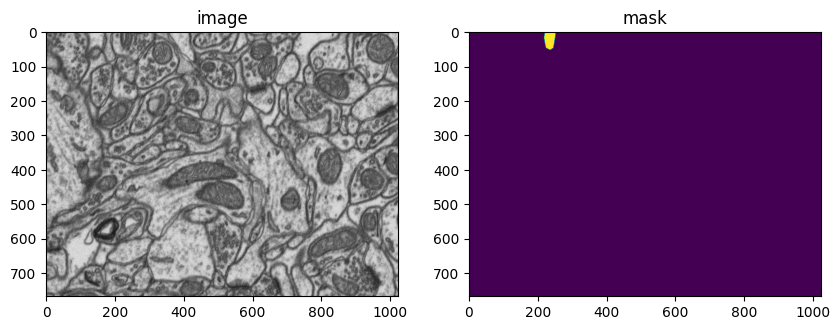

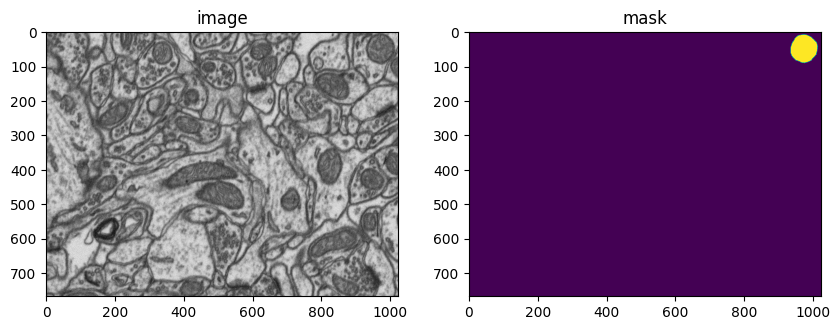

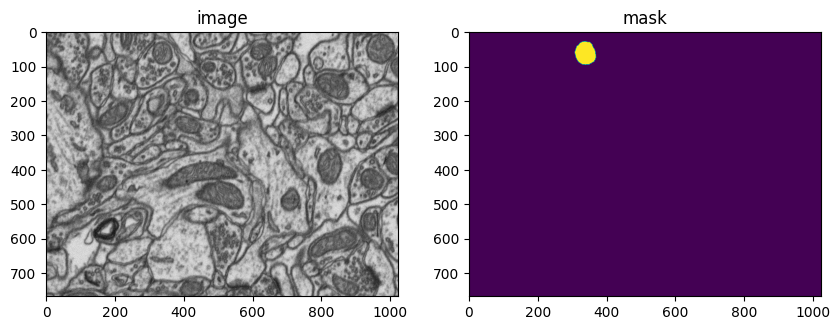

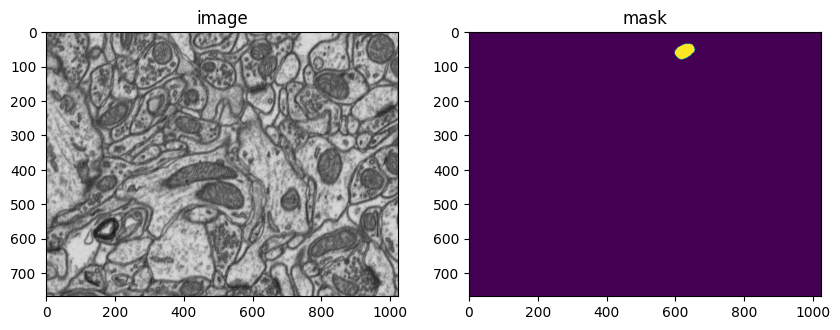

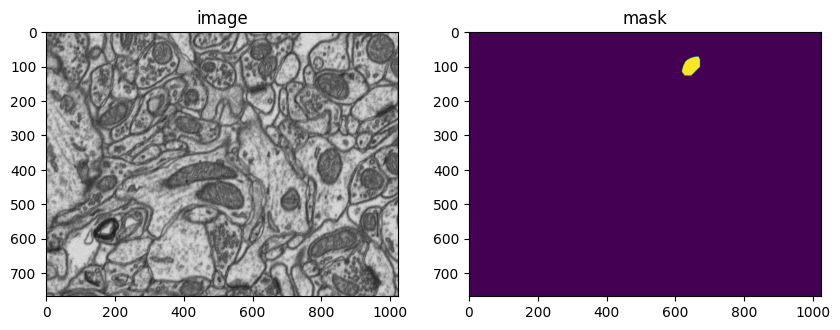

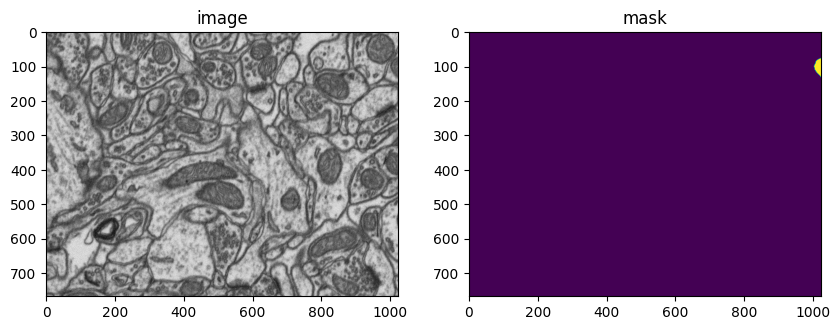

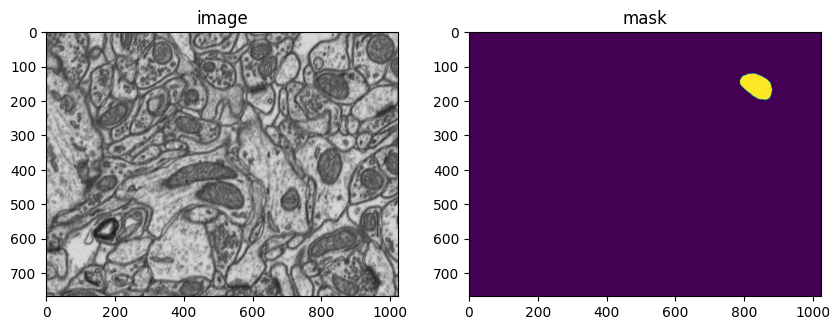

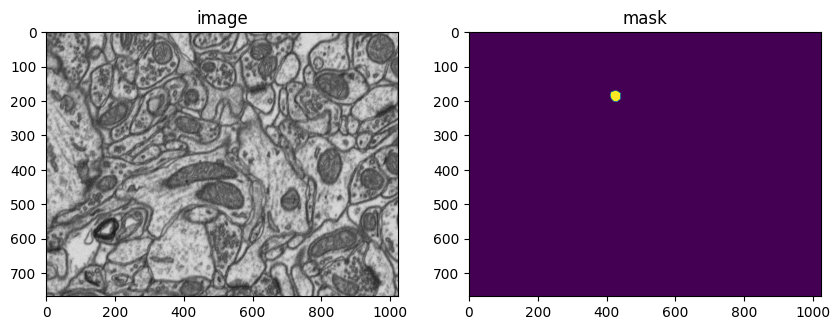

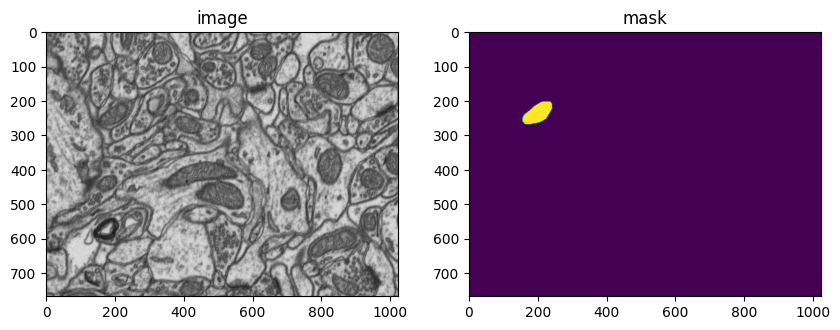

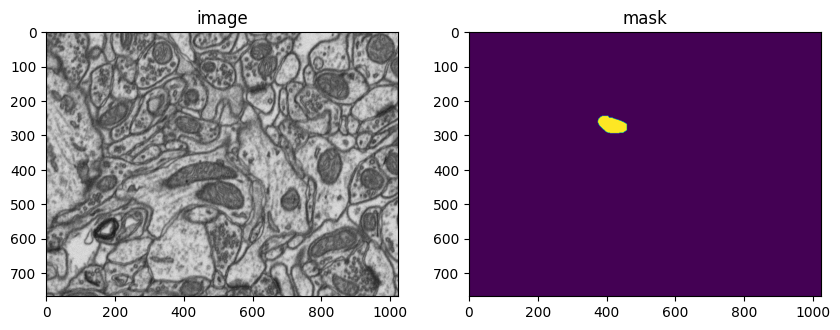

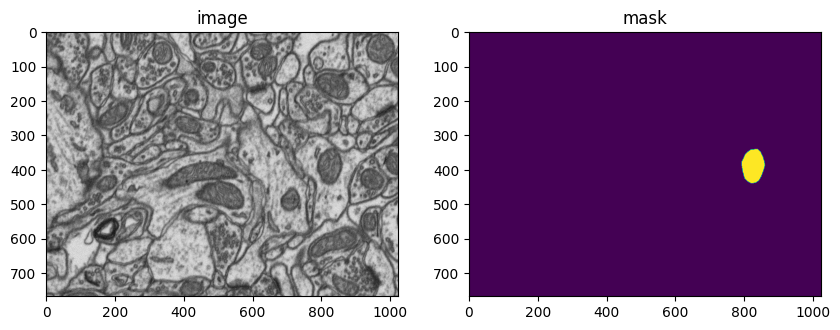

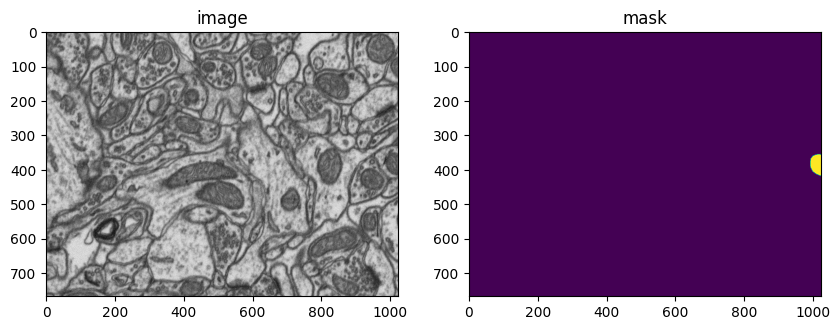

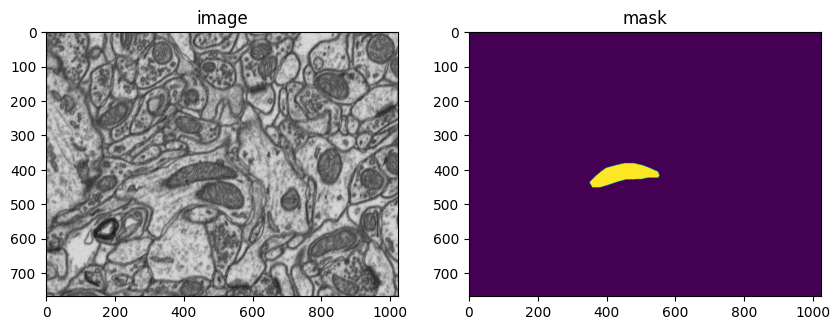

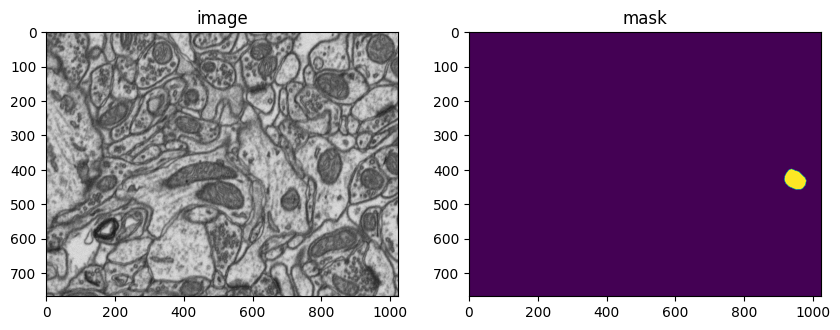

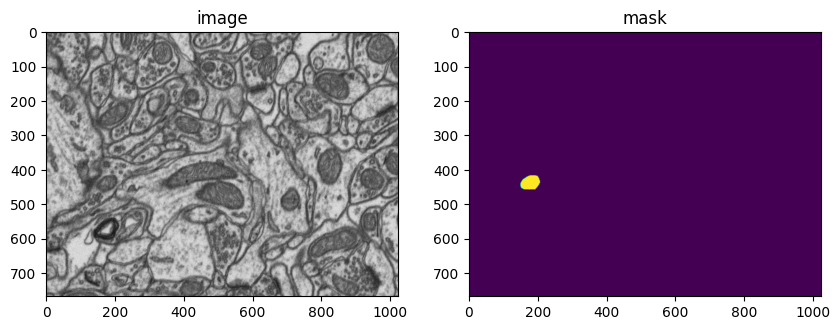

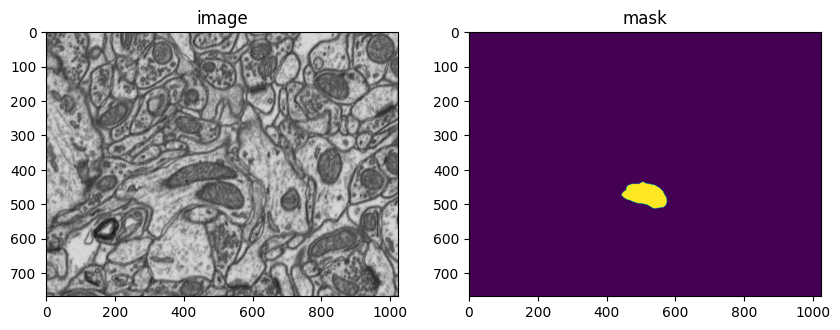

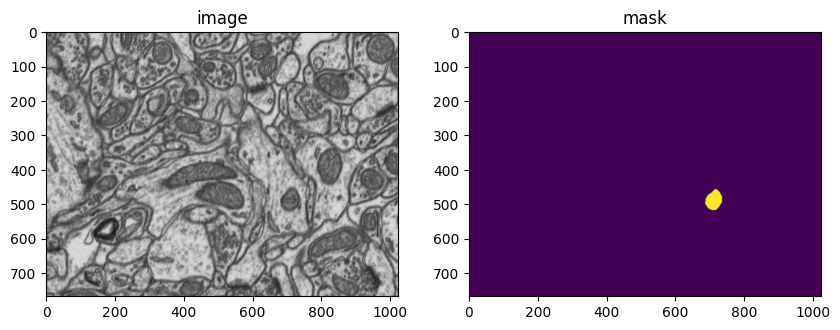

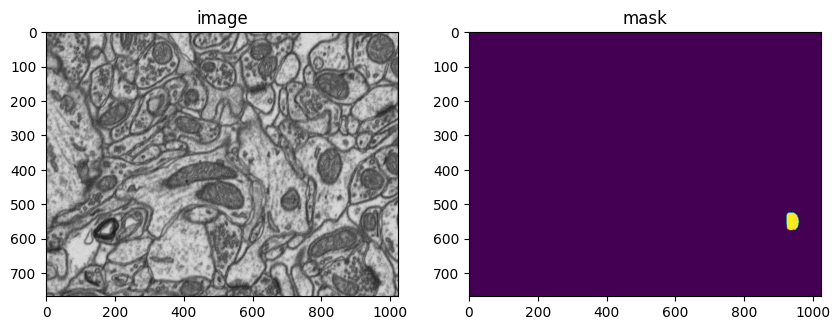

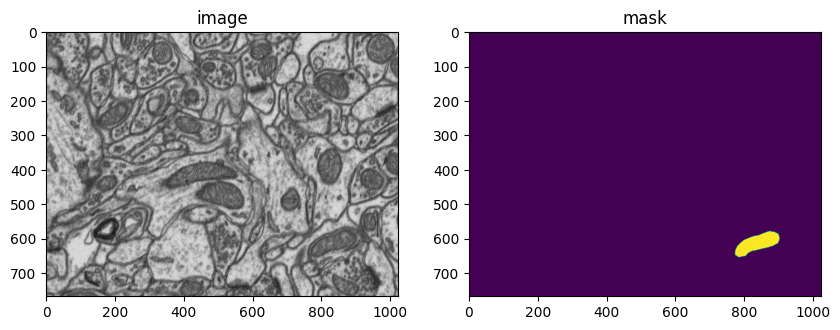

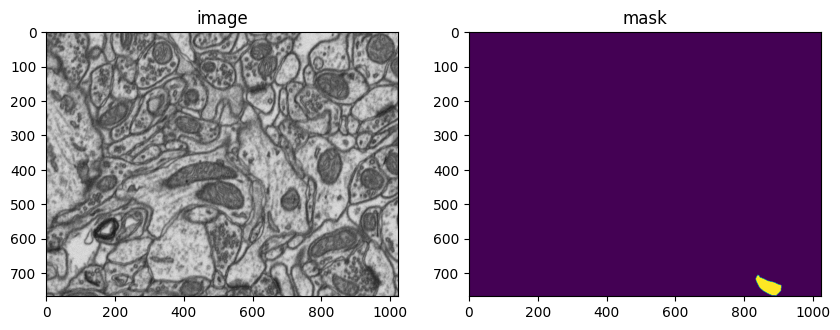

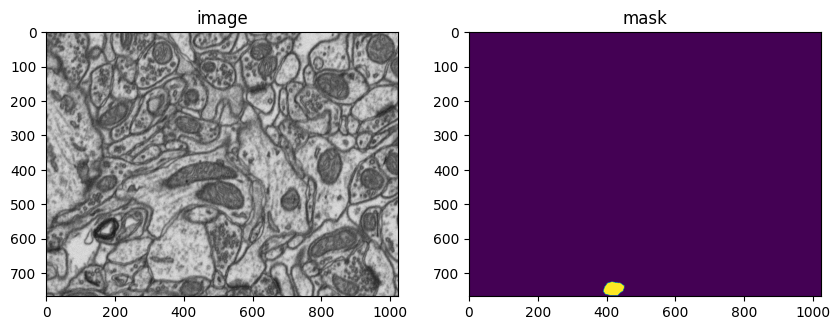

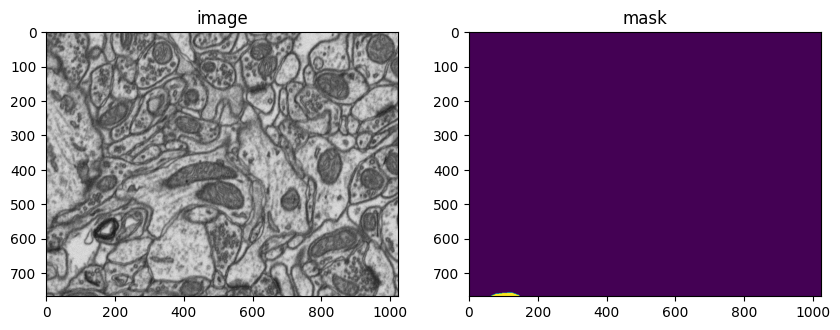

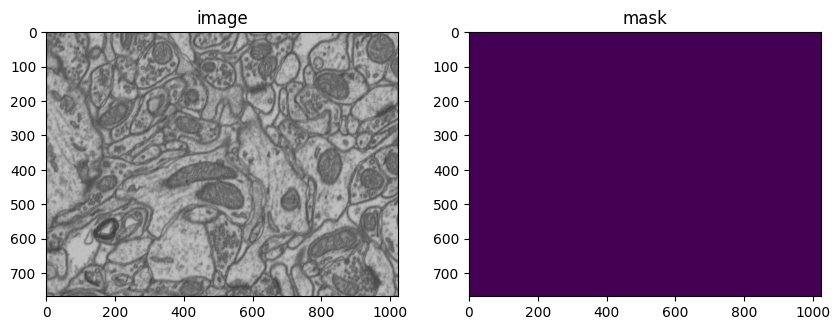

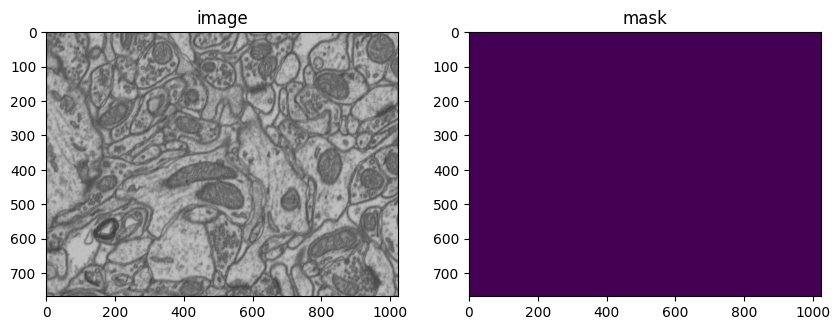

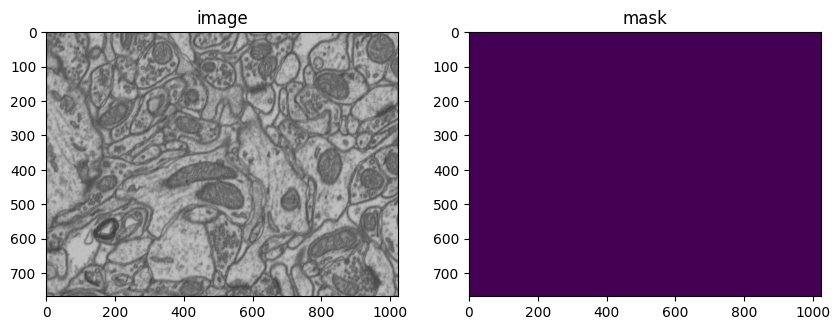

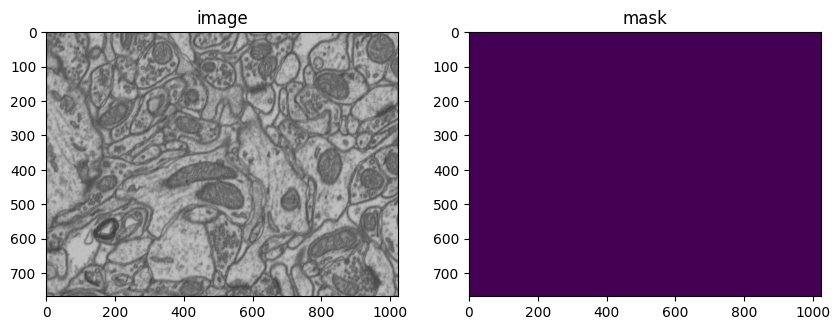

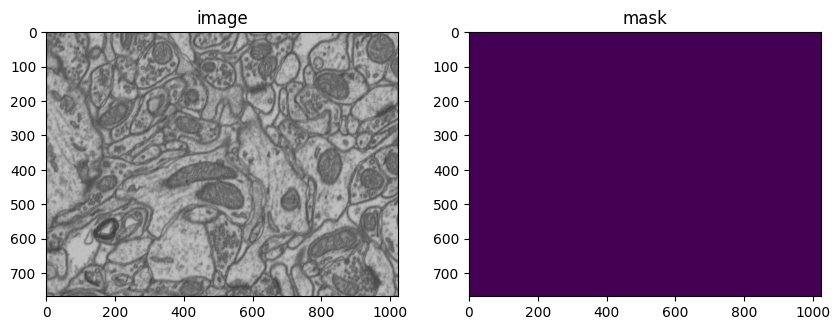

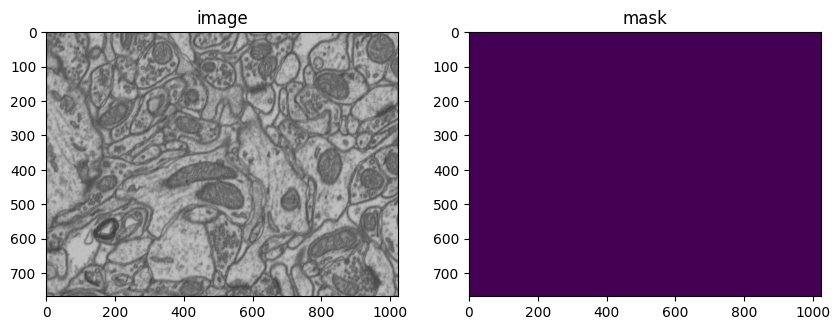

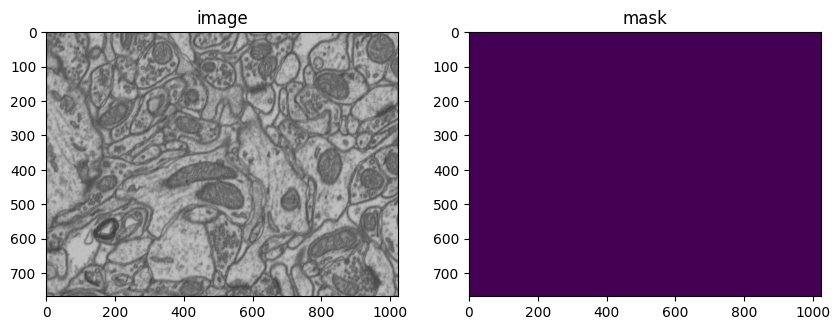

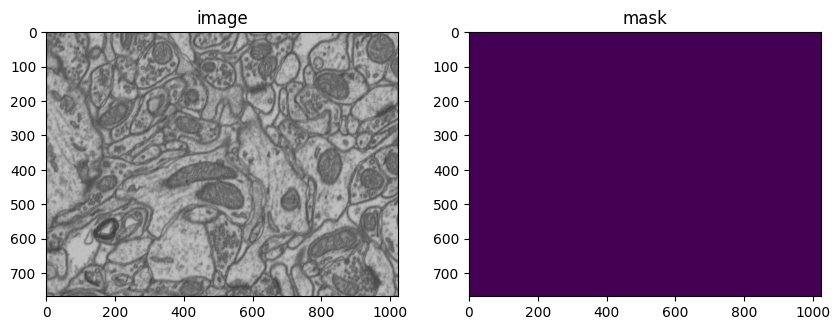

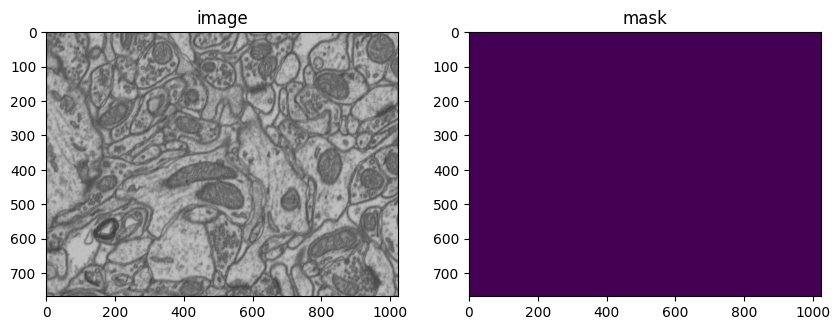

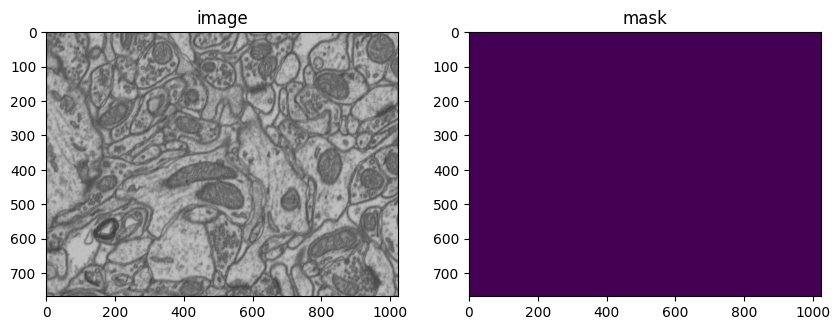

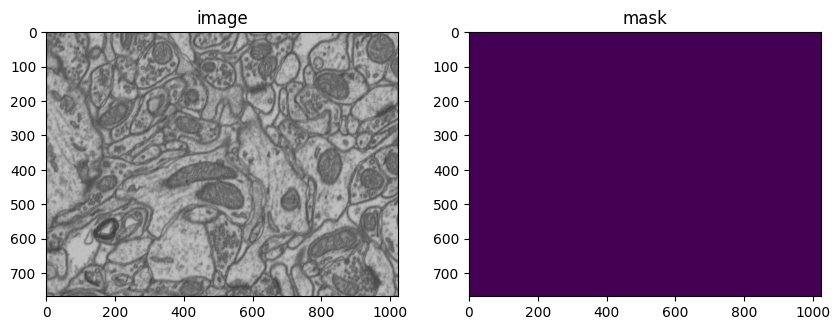

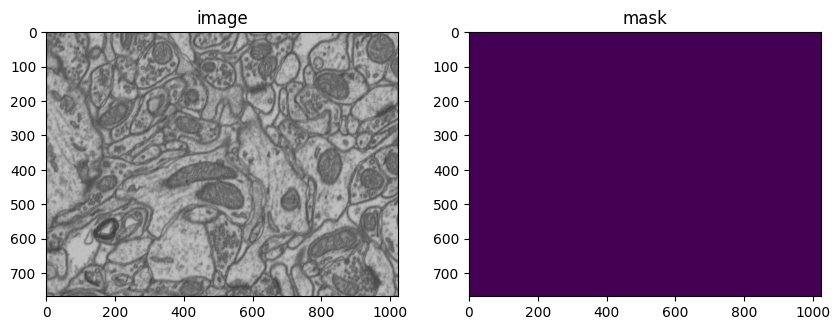

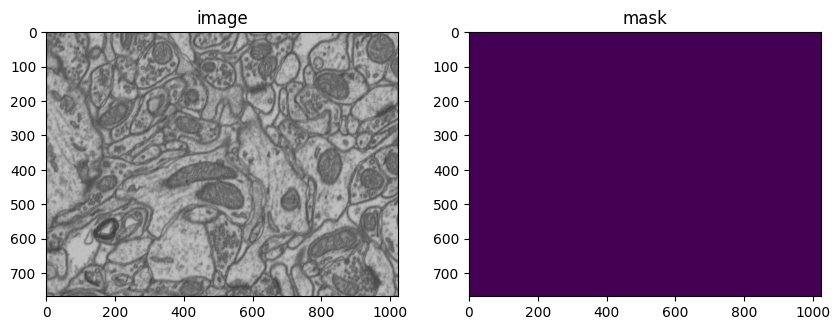

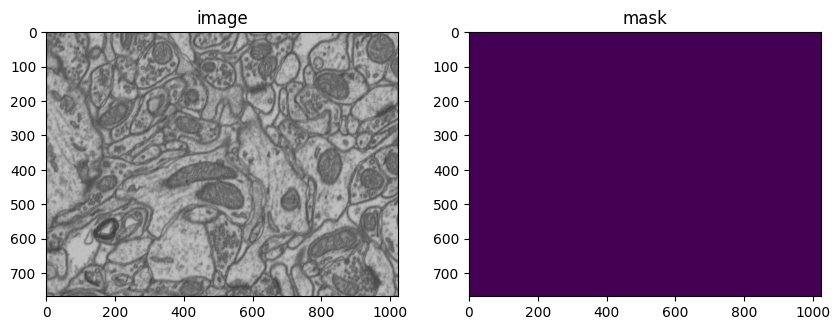

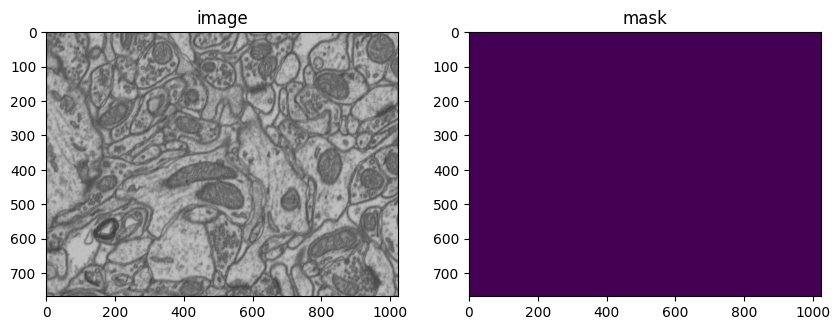

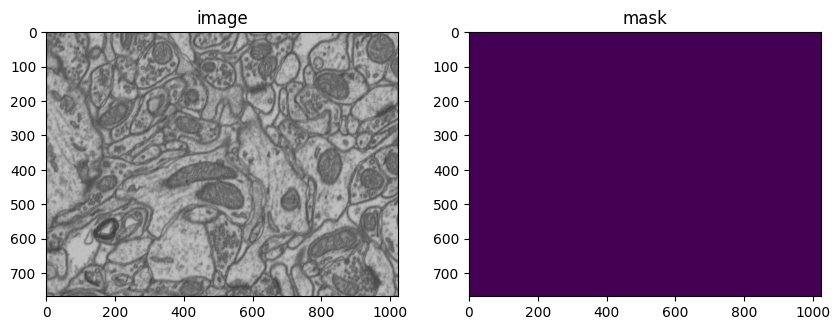

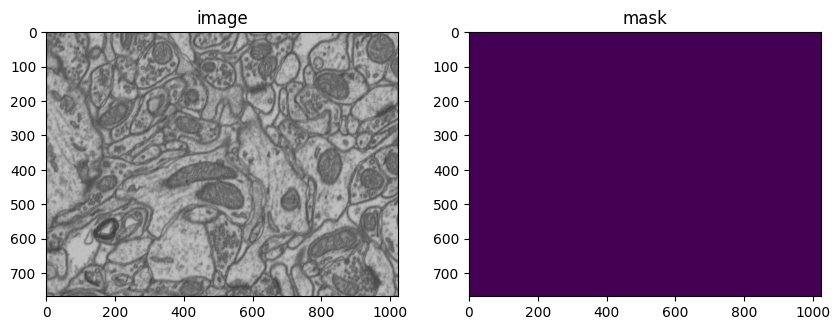

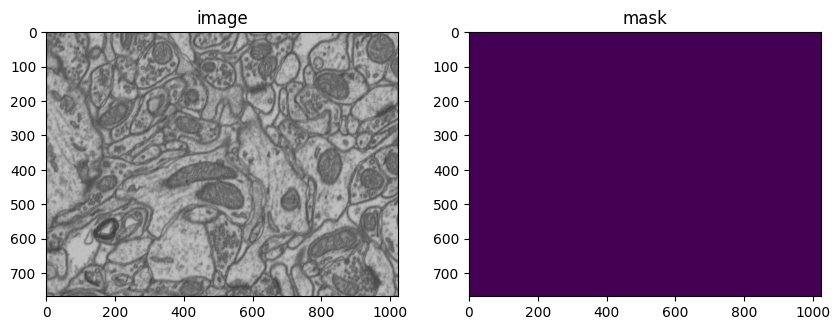

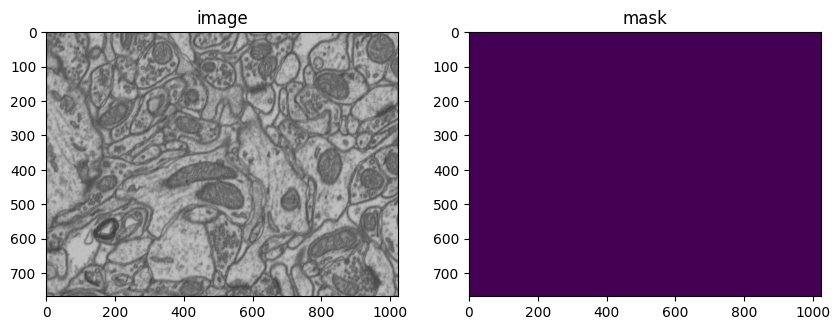

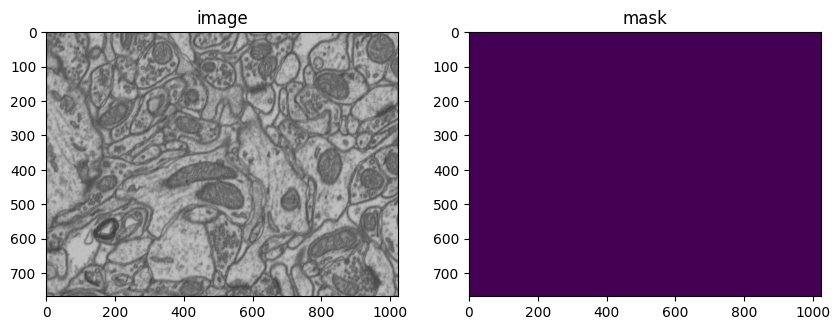

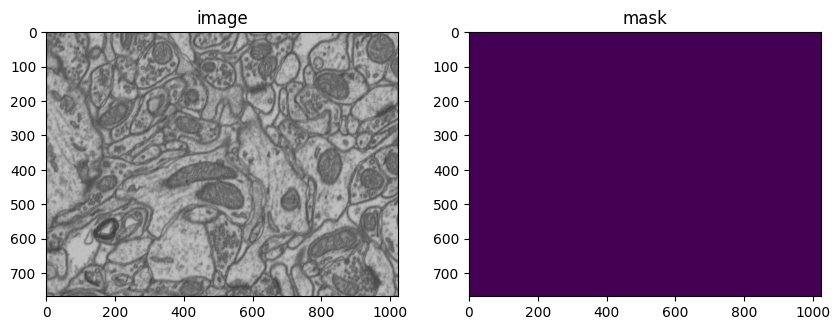

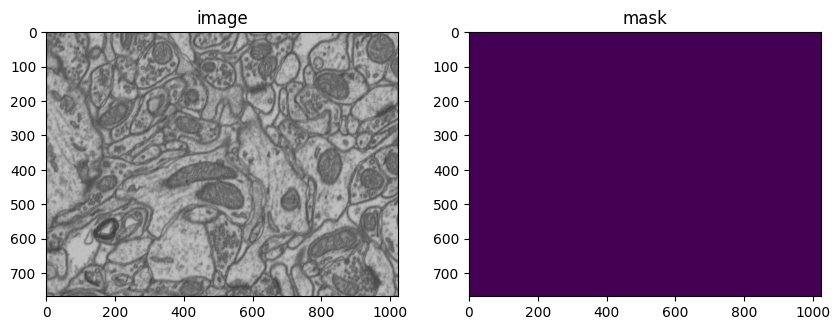

In [18]:
from tnia.plotting.plt_helper import imshow_multi2d


for mask in stacked_labels.mask_list:
    fig = imshow_multi2d([mask['image'], mask['segmentation']], ['image', 'mask'], 1, 2, colormaps=['gray', 'viridis'])



In [19]:
from segment_everything.stacked_label_dataset import StackedLabelDataset
from transformers import SamProcessor

processor = SamProcessor.from_pretrained("facebook/sam-vit-base")
dataset = StackedLabelDataset(stacked_labels.mask_list, processor)
dataset.random_index = True

In [26]:
example = dataset[25]
for k,v in example.items():
  print(k,v.shape)

print()
print('original sizes', example['original_sizes'])
print('input point', example['input_points'])

empty
centroid is [[654, 790]]
random prompt [[940, 98]]

pixel_values torch.Size([3, 1024, 1024])
original_sizes torch.Size([2])
reshaped_input_sizes torch.Size([2])
input_points torch.Size([1, 2])
ground_truth (768, 1024)

original sizes tensor([ 768, 1024])
input point tensor([[940.,  98.]], dtype=torch.float64)


In [27]:
# Create a DataLoader instance for the training dataset
from torch.utils.data import DataLoader
train_dataloader = DataLoader(dataset, batch_size=1, shuffle=True, drop_last=False)

In [28]:
model_type = 'vit_b'
checkpoint = 'sam_vit_b_01ec64.pth'
device = 'cuda:0'

In [29]:
from segment_anything import SamPredictor, sam_model_registry
from segment_everything.weights_helper import get_weights_path

sam_model = sam_model_registry[model_type](checkpoint=get_weights_path('vit_b'))
sam_model.to(device)
test=sam_model.train()

In [30]:
import torch

# Set up the optimizer, hyperparameter tuning will improve performance here
lr = 0.00001
wd = 0
optimizer = torch.optim.Adam(sam_model.mask_decoder.parameters(), lr=lr)
loss_fn = torch.nn.MSELoss()


In [35]:
from statistics import mean

from tqdm import tqdm
from torch.nn.functional import threshold, normalize
from segment_anything.utils.transforms import ResizeLongestSide
transform = ResizeLongestSide(sam_model.image_encoder.img_size)

num_epochs = 15 
losses = []

for epoch in range(num_epochs):
    print('epoch', epoch)

    epoch_losses = []
    for batch in train_dataloader:

        
        input_image = batch['pixel_values'].to(device)
        original_input_size = batch['original_sizes'][0]
        input_size = batch['reshaped_input_sizes'][0]
        input_size = tuple(input_size)
        #print('original_image_size',original_input_size)
        #print('input_size',input_size)
        #print(input_image.shape)

        # we don't update the image encoder so run this part without gradients        
        with torch.no_grad():
            image_embedding = sam_model.image_encoder(input_image)   

            # get the points and convert to tensor
            points_torch = torch.as_tensor(batch['input_points'], dtype=torch.float, device=device)
            
            # we also need a label for the points
            points_label = torch.tensor([1,],device=device)
            points_label = points_label[None, :]

            # get the boxes and convert to tensor
            if 'input_boxes' in batch:
                box_torch = torch.as_tensor(batch['input_boxes'], dtype=torch.float, device=device)
            else:
                box_torch = None
            
            sparse_embeddings, dense_embeddings = sam_model.prompt_encoder(
            points=[points_torch,points_label],
            boxes=box_torch,
            masks=None,
            )

        # run the mask decoder outside the no_grad context (so with gradients)        
        low_res_masks, iou_predictions = sam_model.mask_decoder(
            image_embeddings=image_embedding,
            image_pe=sam_model.prompt_encoder.get_dense_pe(),
            sparse_prompt_embeddings=sparse_embeddings,
            dense_prompt_embeddings=dense_embeddings,
            multimask_output=False,
        )

        #print('low res masks shape',low_res_masks.shape)
        # upscale the masks
        upscaled_masks = sam_model.postprocess_masks(low_res_masks, (768,1024), (768, 1024)).to(device)
        # create binary masks
        binary_mask = normalize(threshold(upscaled_masks, 0.0, 0))
        #binary_mask = normalize(threshold(low_res_masks, 0.0, 0))
        gt_binary_mask = batch['ground_truth'].unsqueeze(0).to(device).float()
        gt_binary_mask = torch.as_tensor(gt_binary_mask > 0, dtype=torch.float32)
        
        # this is a bit of a hack because we are training MSE loss to predict a floating point tensor
        # for which the values are positive and high for the mask and negative and low for the background
        gt_binary_mask[gt_binary_mask == 0] = -1
        # hack.  add a scale
        gt_binary_mask=gt_binary_mask*20
        
        # diagnostics commented out for now
        #print('upscaled masks size', upscaled_masks.size())
        #print('binary mask size',binary_mask.size())
        #print('gt_binary_mask size',gt_binary_mask.size())
        #print('image min max', input_image.max(), input_image.min())
        #print('binary min max',binary_mask.max(), binary_mask.min())
        #print()
        #print('gt_binary_mask shape',gt_binary_mask.shape)

        loss = loss_fn(upscaled_masks, gt_binary_mask)
        #loss = loss_fn(binary_mask, gt_binary_mask)
        optimizer.zero_grad()

        
        #print('gt_min_max',gt_binary_mask.max(), gt_binary_mask.min())
        #print(loss)
        #print()

        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())

    losses.append(epoch_losses)
    print(f'EPOCH: {epoch}')
    print(f'Mean loss: {mean(epoch_losses)}')
        
        
 

epoch 0
EPOCH: 0
Mean loss: 2.656200509179722
epoch 1
EPOCH: 1
Mean loss: 3.2237461480227383
epoch 2
EPOCH: 2
Mean loss: 2.5596497627821835
epoch 3
EPOCH: 3
Mean loss: 3.018130339004777
epoch 4
EPOCH: 4
Mean loss: 2.2632135152816772
epoch 5
EPOCH: 5
Mean loss: 2.273631975054741
epoch 6
EPOCH: 6
Mean loss: 2.272849803621119
epoch 7
EPOCH: 7
Mean loss: 2.160564610903913
epoch 8
EPOCH: 8
Mean loss: 1.6698091287504544
epoch 9
EPOCH: 9
Mean loss: 1.6558679850264029
epoch 10
EPOCH: 10
Mean loss: 1.7252084145491773
epoch 11
EPOCH: 11
Mean loss: 1.8665989230979572
epoch 12
EPOCH: 12
Mean loss: 1.5046189562840895
epoch 13
EPOCH: 13
Mean loss: 1.6886685151945462
epoch 14
EPOCH: 14
Mean loss: 1.443672170693224


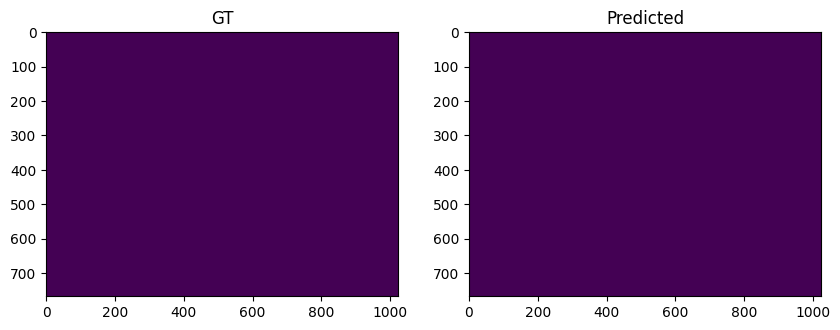

In [33]:
from tnia.plotting.plt_helper import imshow_multi2d

gt_binary_mask_ = gt_binary_mask.detach().cpu().numpy().squeeze()
binary_mask_ = binary_mask.detach().cpu().numpy().squeeze()

fig = imshow_multi2d([gt_binary_mask_, binary_mask_], ['GT', 'Predicted'], 1, 2)

In [34]:
# Save the model's state dictionary to a file
torch.save(sam_model.state_dict(), parent_path / "mito_model_checkpoint4.pth")

In [35]:
from segment_anything.automatic_mask_generator import SamAutomaticMaskGenerator

In [36]:
import numpy as np
test_image = stacked_labels.image
test_image_ = np.stack([test_image,test_image,test_image],axis=-1)
generator = SamAutomaticMaskGenerator(sam_model, points_per_side=32, pred_iou_thresh=0.1, stability_score_thresh=0.1)#, box_nms_thresh=1, )
results = generator.generate(test_image_)
print(len(results))

216


In [37]:
import napari
from  napari_segment_everything import segment_everything
viewer = napari.Viewer()
segment_everything_widget=segment_everything.NapariSegmentEverything(viewer)
viewer.window.add_dock_widget(segment_everything_widget)
segment_everything_widget.load_project(test_image_, results)
#viewer.add_labels(data['binary'])


area 3 785736
label_num 1 216
solidity 0.1132404181184669 1.0
circularity 0.04621962018524543 3.2340725067158833
mean_intensity 69.52734375 190.0380228136882
10th_percentile_intensity 55.0 180.79999999999998
mean_hue 0.0 0.0
mean_saturation 0.0 0.0
predicted_iou 0.4585132598876953 0.9698431491851807
stability_score 0.1016802042722702 0.9738873839378357
